In [1]:
import glob, os
import pathlib
import json
import yaml
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from pprint import pprint

%matplotlib inline

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

# saving the ML model to pickle file and load it
import pickle

In [3]:
# avoid the module's method call deprecation
try:
    collectionsAbc = collections.abc
except AttributeError:
    collectionsAbc = collections

Configuring Juputer's options to present more things to the output.

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Functions to use

## Function to fully flatten each json file

In [5]:
def flatten_dict_full(d, sep="_"):
    obj = collections.OrderedDict()

    def recurse(t, parent_key=""):
        
        if isinstance(t, list):
            for i in range(len(t)):
                recurse(t[i], parent_key + sep + str(i) if parent_key else str(i))
        elif isinstance(t,dict):
            for k, v in t.items():
                recurse(v, parent_key + sep + k if parent_key else k)
        else:
            obj[parent_key] = t
    recurse(d)

    return obj

# Load Data GroundTruth

## Path declaration

In [6]:
path_obj = pathlib.Path().absolute()

In [7]:
path_app = path_obj.as_posix()
# print('Current path:', path_app)
print('Type:', type(path_app))

Type: <class 'str'>


In [8]:
path_app = os.path.join(os.path.abspath(os.getcwd()), os.pardir)
# path = os.path.join(path, 'danceability', 'features', 'mp3')
print('Current path:', path_app)
print('Type:', type(path_app))

Current path: /Users/pantelistzamalis/Desktop/google2020/gsoc_ml_infrastructure/notebooks/..
Type: <class 'str'>


## Count all the JSON data included in files

In [9]:
counter = 0
for root, dirs, files in os.walk(path_app):
    for file in files:
        if file.endswith(".json"):
#             print(os.path.join(root, file))
            counter += 1
            
print('counted json files:', counter)

counted json files: 10472


## Load the GroundTruth file

In [10]:
with open(os.path.join(path_app, 'datasets/danceability/metadata/groundtruth.yaml'), 'r') as stream:
    try:
        groundTr_data = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [11]:
# pprint(groundTr_data)

In [12]:
# pprint(groundTr_data['groundTruth'])

In [13]:
len(groundTr_data['groundTruth'].keys())

225

## Check the unique folders with tracks and sort them alphabetically

In [14]:
labeled_tracks = groundTr_data['groundTruth']

### Split the keys in Folder - Track Name

In [15]:
folders = []
for key in labeled_tracks:
    key = key.split('/')
    folders.append(key[0])

In [16]:
print(folders[:15])

['Alternative', 'Alternative', 'Alternative', 'Alternative', 'Alternative', 'Alternative', 'Alternative', 'Alternative', 'Alternative', 'Blues', 'Blues', 'Blues', 'Blues', 'Blues', 'Blues']


### Check the folders

In [17]:
folders = set(folders)
folders = list(folders)
folders.sort()
folders

['Alternative',
 'Blues',
 'Classical',
 'Country',
 'Dance and House',
 'Folk and New Age',
 'Hip-Hop and Rap',
 'House & Garage and Grime',
 'Jazz',
 'Jungle and D&B',
 'Latin',
 'Pop',
 'R&B and Soul',
 'Reggae',
 'Rock and Metal',
 'Techno and Electro',
 'Vocal and Acapella']

## Class Name retrieved from GT file

In [18]:
class_name = groundTr_data['className']

In [19]:
class_name

'danceability'

# Load a DF containing all the tracks (features + GT data)

In [20]:
path_features = os.path.join(path_app, 'datasets', 'danceability', 'features')
low_level_dir = ''
if len(os.listdir(path_features)) == 0:
    print("Directory is empty")
else:
    print("Directory is not empty")
    directory_contents = os.listdir(path_features)
    if 'mp3' in directory_contents:
        low_level_dir = 'mp3'
    elif 'orig' in directory_contents:
        low_level_dir = 'orig'
    else:
        low_level_dir = ''
        print('There is no valid low-level data inside the features directory')
print('Low-level directory:', low_level_dir)

Directory is not empty
Low-level directory: mp3


In [21]:
path_low_level = os.path.join(path_app, 'datasets/danceability', 'features', low_level_dir)

In [22]:
# path_low_level

In [23]:
if low_level_dir != '':
    tracks = []
    for key, value in labeled_tracks.items():
        track_dict = {}
        key = key.split('/')
        path_tracks = os.path.join(path_low_level, key[0])
        for f_name in os.listdir(path_tracks):
            if f_name.startswith(key[1]):
                track_dict['json_directory'] = key[0]
                track_dict['track'] = key[1]
                track_dict['track_path'] = os.path.join(path_low_level, key[0], f_name)
                track_dict['danceability'] = value
        tracks.append(track_dict)

In [24]:
# pprint(tracks)

In [25]:
len(tracks)

225

In [26]:
df_tracks = pd.DataFrame(data=tracks)

Plot the track's paths

In [27]:
df_tracks.head()

json_directory                                          track  \
0    Alternative         02 Happy Birthday - Altered Images.mp3   
1    Alternative                03 How Soon Is Now - Smiths.mp3   
2    Alternative  04 Pearly Dewdrops' Drops - Cocteau Twins.mp3   
3    Alternative                 06 Mr Brightside - Killers.mp3   
4    Alternative                           06 Song 2 - Blur.mp3   

                                                                                                                                                                         track_path  \
0         /Users/pantelistzamalis/Desktop/google2020/gsoc_ml_infrastructure/notebooks/../datasets/danceability/features/mp3/Alternative/02 Happy Birthday - Altered Images.mp3.json   
1                /Users/pantelistzamalis/Desktop/google2020/gsoc_ml_infrastructure/notebooks/../datasets/danceability/features/mp3/Alternative/03 How Soon Is Now - Smiths.mp3.json   
2  /Users/pantelistzamalis/Desktop/google2020/gsoc_ml_infrastructure/notebooks/../datasets/danceability/features/mp3/Alternative/04 Pearly Dewdrops' Drops - Cocteau Twins.mp3.json   
3                 /Users/pantelistzamalis/Desktop/google2020/gsoc_ml_infrastructure/notebooks/../datasets/danceability/features/mp3/Alternative/06 Mr Brightside - Killers.mp3.json   
4                           /Users/pantelistzamalis/Desktop/google2020/gsoc_ml_infrastructure/notebooks/../datasets/danceability/features/mp3/Alternative/06 Song 2 - Blur.mp3.json   

    danceability  
0      danceable  
1  not_danceable  
2  not_danceable  
3      danceable  
4      danceable

Check the className distribution of the data based on the 'genre_category'

Data distribution based on the genres

In [28]:
df_tracks['json_directory'].value_counts()

Jungle and D&B              22
Latin                       22
Dance and House             21
Hip-Hop and Rap             19
Vocal and Acapella          17
Folk and New Age            16
Techno and Electro          16
R&B and Soul                13
Rock and Metal              13
Reggae                      12
House & Garage and Grime    10
Alternative                  9
Country                      8
Blues                        8
Pop                          7
Classical                    6
Jazz                         6
Name: json_directory, dtype: int64

# Features DF

## Clean the low-level from the unnecessary features and load the rest to a list

Each index/item of the list contains the cleaned dictionary low-level data, flattened by the relevant function

In [29]:
list_feats_tracks = []

In [30]:
list_feats_tracks.clear()  # clear the list if it not empty

counter_items_transformed = 0
for index, row in df_tracks.iterrows():
    f = open(row['track_path'])
    data_feats_item = json.load(f)

    # remove unnecessary data
    if 'beats_position' in data_feats_item['rhythm']:
      del data_feats_item['rhythm']['beats_position']
    
    # data dictionary transformed to a fully flattened dictionary
    data_feats_item = flatten_dict_full(data_feats_item)

    # append to a full tracks features pandas df
    list_feats_tracks.append(dict(data_feats_item))
    
    counter_items_transformed += 1

print('Items parsed and transformed:', counter_items_transformed)

Items parsed and transformed: 225


In [31]:
len(list_feats_tracks)

225

In [32]:
# list_feats_tracks

## Check a flattened low-level instance and save a sample locally

In [33]:
type(list_feats_tracks[0])

dict

In [34]:
example_dict = list_feats_tracks[0]

In [35]:
df_sample = pd.DataFrame.from_dict(example_dict, orient='index', columns=['low_level_data'])

In [36]:
df_sample.reset_index(level=0, inplace=True)

In [37]:
df_sample.columns = ['low_level_data', 'low_level_values']
df_sample.head()

low_level_data low_level_values
0        lowlevel_average_loudness         0.940232
1   lowlevel_barkbands_crest_dmean          2.76666
2  lowlevel_barkbands_crest_dmean2           4.4483
3    lowlevel_barkbands_crest_dvar          5.74581
4   lowlevel_barkbands_crest_dvar2          14.9876

In [38]:
# df_sample.to_csv('sample_flattened_low_level_data.csv')

## Transform the low-level features instances to DF

In [39]:
df_feats_tracks = pd.DataFrame(list_feats_tracks, columns=list_feats_tracks[0].keys())

In [40]:
df_feats_tracks.head()

lowlevel_average_loudness  lowlevel_barkbands_crest_dmean  \
0                   0.940232                        2.766660   
1                   0.918468                        2.675291   
2                   0.903639                        2.680212   
3                   0.964146                        2.334805   
4                   0.923212                        2.654776   

   lowlevel_barkbands_crest_dmean2  lowlevel_barkbands_crest_dvar  \
0                         4.448297                       5.745806   
1                         4.377324                       6.211648   
2                         4.377909                       5.717108   
3                         3.876004                       6.314280   
4                         4.302909                       6.634628   

   lowlevel_barkbands_crest_dvar2  lowlevel_barkbands_crest_max  \
0                       14.987641                     26.722847   
1                       15.621523                     26.676046   
2                       13.717224                     24.490746   
3                       16.660341                     24.082594   
4                       16.935333                     26.224245   

   lowlevel_barkbands_crest_mean  lowlevel_barkbands_crest_median  \
0                      10.807129                         9.691339   
1                       8.789837                         8.108212   
2                       8.958855                         8.116771   
3                       7.989666                         7.193906   
4                       9.249996                         8.158960   

   lowlevel_barkbands_crest_min  lowlevel_barkbands_crest_var  \
0                      2.798266                     24.122204   
1                      2.419000                     12.385103   
2                      2.538304                     14.455623   
3                      2.510511                     11.031219   
4                      2.489789                     18.725180   

   lowlevel_barkbands_flatness_db_dmean  \
0                              0.023720   
1                              0.021670   
2                              0.020029   
3                              0.017094   
4                              0.020814   

   lowlevel_barkbands_flatness_db_dmean2  lowlevel_barkbands_flatness_db_dvar  \
0                               0.035958                             0.000526   
1                               0.033876                             0.000391   
2                               0.032708                             0.000378   
3                               0.027388                             0.000365   
4                               0.032149                             0.000563   

   lowlevel_barkbands_flatness_db_dvar2  lowlevel_barkbands_flatness_db_max  \
0                              0.001158                            0.627938   
1                              0.000961                            0.448718   
2                              0.000948                            0.291119   
3                              0.000918                            0.561661   
4                              0.001232                            0.386401   

   lowlevel_barkbands_flatness_db_mean  lowlevel_barkbands_flatness_db_median  \
0                             0.176747                               0.146083   
1                             0.113029                               0.105044   
2                             0.126804                               0.123771   
3                             0.096527                               0.074531   
4                             0.115602                               0.095726   

   lowlevel_barkbands_flatness_db_min  lowlevel_barkbands_flatness_db_var  \
0                            0.040839                            0.010974   
1                            0.025457                            0.001940   
2                            0.045240                  

In [41]:
df_feats_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Columns: 2674 entries, lowlevel_average_loudness to tonal_key_scale
dtypes: float64(2575), int64(79), object(20)
memory usage: 4.6+ MB


In [42]:
df_feats_tracks.shape

(225, 2674)

## Concatenate the tracks DF with the feats DF

In [43]:
df_tracks.columns

Index(['json_directory', 'track', 'track_path', 'danceability'], dtype='object')

In [44]:
df_tracks.drop(labels=['track_path'], axis=1, inplace=True)

In [45]:
df_tracks.head()

json_directory                                          track   danceability
0    Alternative         02 Happy Birthday - Altered Images.mp3      danceable
1    Alternative                03 How Soon Is Now - Smiths.mp3  not_danceable
2    Alternative  04 Pearly Dewdrops' Drops - Cocteau Twins.mp3  not_danceable
3    Alternative                 06 Mr Brightside - Killers.mp3      danceable
4    Alternative                           06 Song 2 - Blur.mp3      danceable

In [46]:
df_feats_tracks.head()

lowlevel_average_loudness  lowlevel_barkbands_crest_dmean  \
0                   0.940232                        2.766660   
1                   0.918468                        2.675291   
2                   0.903639                        2.680212   
3                   0.964146                        2.334805   
4                   0.923212                        2.654776   

   lowlevel_barkbands_crest_dmean2  lowlevel_barkbands_crest_dvar  \
0                         4.448297                       5.745806   
1                         4.377324                       6.211648   
2                         4.377909                       5.717108   
3                         3.876004                       6.314280   
4                         4.302909                       6.634628   

   lowlevel_barkbands_crest_dvar2  lowlevel_barkbands_crest_max  \
0                       14.987641                     26.722847   
1                       15.621523                     26.676046   
2                       13.717224                     24.490746   
3                       16.660341                     24.082594   
4                       16.935333                     26.224245   

   lowlevel_barkbands_crest_mean  lowlevel_barkbands_crest_median  \
0                      10.807129                         9.691339   
1                       8.789837                         8.108212   
2                       8.958855                         8.116771   
3                       7.989666                         7.193906   
4                       9.249996                         8.158960   

   lowlevel_barkbands_crest_min  lowlevel_barkbands_crest_var  \
0                      2.798266                     24.122204   
1                      2.419000                     12.385103   
2                      2.538304                     14.455623   
3                      2.510511                     11.031219   
4                      2.489789                     18.725180   

   lowlevel_barkbands_flatness_db_dmean  \
0                              0.023720   
1                              0.021670   
2                              0.020029   
3                              0.017094   
4                              0.020814   

   lowlevel_barkbands_flatness_db_dmean2  lowlevel_barkbands_flatness_db_dvar  \
0                               0.035958                             0.000526   
1                               0.033876                             0.000391   
2                               0.032708                             0.000378   
3                               0.027388                             0.000365   
4                               0.032149                             0.000563   

   lowlevel_barkbands_flatness_db_dvar2  lowlevel_barkbands_flatness_db_max  \
0                              0.001158                            0.627938   
1                              0.000961                            0.448718   
2                              0.000948                            0.291119   
3                              0.000918                            0.561661   
4                              0.001232                            0.386401   

   lowlevel_barkbands_flatness_db_mean  lowlevel_barkbands_flatness_db_median  \
0                             0.176747                               0.146083   
1                             0.113029                               0.105044   
2                             0.126804                               0.123771   
3                             0.096527                               0.074531   
4                             0.115602                               0.095726   

   lowlevel_barkbands_flatness_db_min  lowlevel_barkbands_flatness_db_var  \
0                            0.040839                            0.010974   
1                            0.025457                            0.001940   
2                            0.045240                  

In [47]:
df_feats_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Columns: 2674 entries, lowlevel_average_loudness to tonal_key_scale
dtypes: float64(2575), int64(79), object(20)
memory usage: 4.6+ MB


In [48]:
df_full_tracks = pd.concat([df_tracks, df_feats_tracks], axis=1)

In [49]:
df_full_tracks.head()

json_directory                                          track  \
0    Alternative         02 Happy Birthday - Altered Images.mp3   
1    Alternative                03 How Soon Is Now - Smiths.mp3   
2    Alternative  04 Pearly Dewdrops' Drops - Cocteau Twins.mp3   
3    Alternative                 06 Mr Brightside - Killers.mp3   
4    Alternative                           06 Song 2 - Blur.mp3   

    danceability  lowlevel_average_loudness  lowlevel_barkbands_crest_dmean  \
0      danceable                   0.940232                        2.766660   
1  not_danceable                   0.918468                        2.675291   
2  not_danceable                   0.903639                        2.680212   
3      danceable                   0.964146                        2.334805   
4      danceable                   0.923212                        2.654776   

   lowlevel_barkbands_crest_dmean2  lowlevel_barkbands_crest_dvar  \
0                         4.448297                       5.745806   
1                         4.377324                       6.211648   
2                         4.377909                       5.717108   
3                         3.876004                       6.314280   
4                         4.302909                       6.634628   

   lowlevel_barkbands_crest_dvar2  lowlevel_barkbands_crest_max  \
0                       14.987641                     26.722847   
1                       15.621523                     26.676046   
2                       13.717224                     24.490746   
3                       16.660341                     24.082594   
4                       16.935333                     26.224245   

   lowlevel_barkbands_crest_mean  lowlevel_barkbands_crest_median  \
0                      10.807129                         9.691339   
1                       8.789837                         8.108212   
2                       8.958855                         8.116771   
3                       7.989666                         7.193906   
4                       9.249996                         8.158960   

   lowlevel_barkbands_crest_min  lowlevel_barkbands_crest_var  \
0                      2.798266                     24.122204   
1                      2.419000                     12.385103   
2                      2.538304                     14.455623   
3                      2.510511                     11.031219   
4                      2.489789                     18.725180   

   lowlevel_barkbands_flatness_db_dmean  \
0                              0.023720   
1                              0.021670   
2                              0.020029   
3                              0.017094   
4                              0.020814   

   lowlevel_barkbands_flatness_db_dmean2  lowlevel_barkbands_flatness_db_dvar  \
0                               0.035958                             0.000526   
1                               0.033876                             0.000391   
2                               0.032708                             0.000378   
3                               0.027388                             0.000365   
4                               0.032149                             0.000563   

   lowlevel_barkbands_flatness_db_dvar2  lowlevel_barkbands_flatness_db_max  \
0                              0.001158                            0.627938   
1                              0.000961                            0.448718   
2                              0.000948                            0.291119   
3                              0.000918                            0.561661   
4                              0.001232                            0.386401   

   lowlevel_barkbands_flatness_db_mean  lowlevel_barkbands_flatness_db_median  \
0                             0.176747                               0.146083   
1                             0.113029                               0.105044   
2                             0.1268

## check for empty values

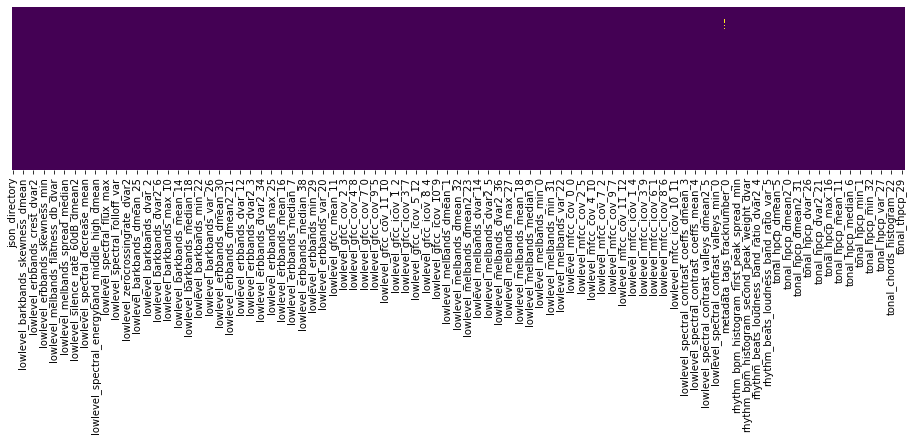

In [50]:
plt.figure(figsize=(16, 3))
sns.heatmap(df_full_tracks.isnull(), yticklabels=False, cbar=False, cmap='viridis')

There are no null values.

# Config Data

In [51]:
with open("../configuration.yaml") as file:
    config_data = yaml.safe_load(file)

In [52]:
config_data

{'ground_truth_directory': 'datasets',
 'acousticbrainz': False,
 'from_disk': True,
 'class_dir': 'danceability',
 'enumeration_columns': ['tonal_chords_key',
  'tonal_chords_scale',
  'tonal_key_key',
  'tonal_key_scale'],
 'remove_columns': ['json_directory', 'track'],
 'exports_directory': 'exports',
 'evaluations_directory': 'evaluations',
 'tracks_in_csv_format': 'tracks_csv',
 'delete_logs': True,
 'log_directory': 'logs',
 'logging_level': 0,
 'scaling': 'standard_scaled',
 'excludedDescriptors': ['metadata.tags*'],
 'processing': {'raw': [],
  'basic': [{'transfo': 'remove',
    'params': {'descriptorNames': ['metadata.*',
      '*dmean*',
      '*dvar*',
      '*.min',
      '*.max',
      '*cov',
      'tonal.thpcp',
      'lowlevel.spectral_energyband_high.*',
      'lowlevel.silence_rate*']}},
   {'transfo': 'enumerate',
    'params': {'descriptorNames': ['tonal.chords_key',
      'tonal.chords_scale',
      'tonal.key_key',
      'tonal.key_scale']}}],
  'lowlevel': [{'tr

In [53]:
def list_descr_handler(descr_list):
    """

    :param descr_list:
    :return:
    """
    keys_list_handle = []
    for item in descr_list:
        if item.endswith(".*"):
            item = item.replace(".*", "_")
        elif item.startswith("*."):
            item = item.replace("*.", "_")
        else:
            item = item.replace("*", "")
        item = item.replace(".", "_")
        keys_list_handle.append(item)
    return keys_list_handle

In [54]:
def descr_remover(df, descr_remove_list):
    """

    :param df:
    :param descr_remove_list:
    :return:
    """
    columns_list = list(df.columns)
    columns_del_list = []
    for item in descr_remove_list:
        for del_item in columns_list:
            if re.search(item, del_item):
                columns_del_list.append(del_item)
    df_used_descr = df.drop(columns=columns_del_list, axis=1)
    return df_used_descr

# Clean

In [55]:
def cleaner(config, df):
    cleaning_columns_list = config["excludedDescriptors"]
    cleaning_columns_list = list_descr_handler(cleaning_columns_list)
    print("Cleaner for columns: {}".format(cleaning_columns_list))
    df = descr_remover(df, cleaning_columns_list)
    print("Shape of the df after the data cleaning: \n{}".format(df.shape))
    return df

In [56]:
df_tracks_clean = cleaner(config=config_data, df=df_feats_tracks)

Cleaner for columns: ['metadata_tags']
Shape of the df after the data cleaning: 
(225, 2664)


In [57]:
df_tracks_clean.head()

lowlevel_average_loudness  lowlevel_barkbands_crest_dmean  \
0                   0.940232                        2.766660   
1                   0.918468                        2.675291   
2                   0.903639                        2.680212   
3                   0.964146                        2.334805   
4                   0.923212                        2.654776   

   lowlevel_barkbands_crest_dmean2  lowlevel_barkbands_crest_dvar  \
0                         4.448297                       5.745806   
1                         4.377324                       6.211648   
2                         4.377909                       5.717108   
3                         3.876004                       6.314280   
4                         4.302909                       6.634628   

   lowlevel_barkbands_crest_dvar2  lowlevel_barkbands_crest_max  \
0                       14.987641                     26.722847   
1                       15.621523                     26.676046   
2                       13.717224                     24.490746   
3                       16.660341                     24.082594   
4                       16.935333                     26.224245   

   lowlevel_barkbands_crest_mean  lowlevel_barkbands_crest_median  \
0                      10.807129                         9.691339   
1                       8.789837                         8.108212   
2                       8.958855                         8.116771   
3                       7.989666                         7.193906   
4                       9.249996                         8.158960   

   lowlevel_barkbands_crest_min  lowlevel_barkbands_crest_var  \
0                      2.798266                     24.122204   
1                      2.419000                     12.385103   
2                      2.538304                     14.455623   
3                      2.510511                     11.031219   
4                      2.489789                     18.725180   

   lowlevel_barkbands_flatness_db_dmean  \
0                              0.023720   
1                              0.021670   
2                              0.020029   
3                              0.017094   
4                              0.020814   

   lowlevel_barkbands_flatness_db_dmean2  lowlevel_barkbands_flatness_db_dvar  \
0                               0.035958                             0.000526   
1                               0.033876                             0.000391   
2                               0.032708                             0.000378   
3                               0.027388                             0.000365   
4                               0.032149                             0.000563   

   lowlevel_barkbands_flatness_db_dvar2  lowlevel_barkbands_flatness_db_max  \
0                              0.001158                            0.627938   
1                              0.000961                            0.448718   
2                              0.000948                            0.291119   
3                              0.000918                            0.561661   
4                              0.001232                            0.386401   

   lowlevel_barkbands_flatness_db_mean  lowlevel_barkbands_flatness_db_median  \
0                             0.176747                               0.146083   
1                             0.113029                               0.105044   
2                             0.126804                               0.123771   
3                             0.096527                               0.074531   
4                             0.115602                               0.095726   

   lowlevel_barkbands_flatness_db_min  lowlevel_barkbands_flatness_db_var  \
0                            0.040839                            0.010974   
1                            0.025457                            0.001940   
2                            0.045240                  

In [58]:
df_tracks_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Columns: 2664 entries, lowlevel_average_loudness to tonal_key_scale
dtypes: float64(2575), int64(79), object(10)
memory usage: 4.6+ MB


# Remove

In [59]:
remove_list = list_descr_handler(config_data["processing"]["normalized"][0]["params"]["descriptorNames"])
print(remove_list)
df_tracks_remove = descr_remover(df_tracks_clean, remove_list)
print("items removed related to: {}".format(remove_list))

['metadata_', 'dmean', 'dvar', '_min', '_max', 'cov', 'tonal_thpcp', 'lowlevel_spectral_energyband_high_', 'lowlevel_silence_rate']
items removed related to: ['metadata_', 'dmean', 'dvar', '_min', '_max', 'cov', 'tonal_thpcp', 'lowlevel_spectral_energyband_high_', 'lowlevel_silence_rate']


In [60]:
df_tracks_remove.head()

lowlevel_average_loudness  lowlevel_barkbands_crest_mean  \
0                   0.940232                      10.807129   
1                   0.918468                       8.789837   
2                   0.903639                       8.958855   
3                   0.964146                       7.989666   
4                   0.923212                       9.249996   

   lowlevel_barkbands_crest_median  lowlevel_barkbands_crest_var  \
0                         9.691339                     24.122204   
1                         8.108212                     12.385103   
2                         8.116771                     14.455623   
3                         7.193906                     11.031219   
4                         8.158960                     18.725180   

   lowlevel_barkbands_flatness_db_mean  lowlevel_barkbands_flatness_db_median  \
0                             0.176747                               0.146083   
1                             0.113029                               0.105044   
2                             0.126804                               0.123771   
3                             0.096527                               0.074531   
4                             0.115602                               0.095726   

   lowlevel_barkbands_flatness_db_var  lowlevel_barkbands_kurtosis_mean  \
0                            0.010974                          6.762696   
1                            0.001940                          2.929853   
2                            0.000906                          0.766920   
3                            0.006061                          2.024123   
4                            0.003345                          3.395818   

   lowlevel_barkbands_kurtosis_median  lowlevel_barkbands_kurtosis_var  \
0                            1.556325                       522.650879   
1                            0.664307                        45.587414   
2                           -0.279621                        13.023299   
3                            0.724629                        17.895559   
4                            0.216489                       102.163467   

   lowlevel_barkbands_skewness_mean  lowlevel_barkbands_skewness_median  \
0                          1.535155                            1.272417   
1                          1.394414                            1.197365   
2                          0.390109                            0.189988   
3                          1.261587                            1.155293   
4                          1.391440                            1.109180   

   lowlevel_barkbands_skewness_var  lowlevel_barkbands_spread_mean  \
0                         2.187619                       19.025879   
1                         1.433683                       27.515455   
2                         1.273380                       31.218849   
3                         0.704251                       29.787991   
4                         1.551799                       28.817030   

   lowlevel_barkbands_spread_median  lowlevel_barkbands_spread_var  \
0                         17.504620                     164.326553   
1                         26.352985                     159.659363   
2                         30.656132                     172.206955   
3                         29.554728                     162.274734   
4                         31.164455                     211.944901   

   lowlevel_dissonance_mean  lowlevel_dissonance_median  \
0                  0.437224                    0.460024   
1                  0.473310                    0.478164   
2                  0.483429                    0.487293   
3                  0.471935                    0.478796   
4                  0.470958                    0.481814   

   lowlevel_dissonance_var  lowlevel_dynamic_complexity  \
0                 0.005112                     3.144951   
1                 0.000381                     3.001131   
2      

In [61]:
df_tracks_remove.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Columns: 679 entries, lowlevel_average_loudness to tonal_key_scale
dtypes: float64(663), int64(12), object(4)
memory usage: 1.2+ MB


# Enumerate

In [62]:
enumerate_list = list_descr_handler(config_data["processing"]["normalized"][1]["params"]["descriptorNames"])

In [63]:
print(enumerate_list)

['tonal_chords_key', 'tonal_chords_scale', 'tonal_key_key', 'tonal_key_scale']


In [64]:
df_tracks_cat = df_tracks_remove[enumerate_list]

In [65]:
df_tracks_cat.head()

tonal_chords_key tonal_chords_scale tonal_key_key tonal_key_scale
0                A              major             D           minor
1               F#              major            F#           minor
2                D              major             D           major
3               C#              major            C#           major
4                C              minor            G#           major

In [66]:
df_tracks_num = df_tracks_remove.drop(columns=enumerate_list, axis=1)

In [67]:
df_tracks_num.head()

lowlevel_average_loudness  lowlevel_barkbands_crest_mean  \
0                   0.940232                      10.807129   
1                   0.918468                       8.789837   
2                   0.903639                       8.958855   
3                   0.964146                       7.989666   
4                   0.923212                       9.249996   

   lowlevel_barkbands_crest_median  lowlevel_barkbands_crest_var  \
0                         9.691339                     24.122204   
1                         8.108212                     12.385103   
2                         8.116771                     14.455623   
3                         7.193906                     11.031219   
4                         8.158960                     18.725180   

   lowlevel_barkbands_flatness_db_mean  lowlevel_barkbands_flatness_db_median  \
0                             0.176747                               0.146083   
1                             0.113029                               0.105044   
2                             0.126804                               0.123771   
3                             0.096527                               0.074531   
4                             0.115602                               0.095726   

   lowlevel_barkbands_flatness_db_var  lowlevel_barkbands_kurtosis_mean  \
0                            0.010974                          6.762696   
1                            0.001940                          2.929853   
2                            0.000906                          0.766920   
3                            0.006061                          2.024123   
4                            0.003345                          3.395818   

   lowlevel_barkbands_kurtosis_median  lowlevel_barkbands_kurtosis_var  \
0                            1.556325                       522.650879   
1                            0.664307                        45.587414   
2                           -0.279621                        13.023299   
3                            0.724629                        17.895559   
4                            0.216489                       102.163467   

   lowlevel_barkbands_skewness_mean  lowlevel_barkbands_skewness_median  \
0                          1.535155                            1.272417   
1                          1.394414                            1.197365   
2                          0.390109                            0.189988   
3                          1.261587                            1.155293   
4                          1.391440                            1.109180   

   lowlevel_barkbands_skewness_var  lowlevel_barkbands_spread_mean  \
0                         2.187619                       19.025879   
1                         1.433683                       27.515455   
2                         1.273380                       31.218849   
3                         0.704251                       29.787991   
4                         1.551799                       28.817030   

   lowlevel_barkbands_spread_median  lowlevel_barkbands_spread_var  \
0                         17.504620                     164.326553   
1                         26.352985                     159.659363   
2                         30.656132                     172.206955   
3                         29.554728                     162.274734   
4                         31.164455                     211.944901   

   lowlevel_dissonance_mean  lowlevel_dissonance_median  \
0                  0.437224                    0.460024   
1                  0.473310                    0.478164   
2                  0.483429                    0.487293   
3                  0.471935                    0.478796   
4                  0.470958                    0.481814   

   lowlevel_dissonance_var  lowlevel_dynamic_complexity  \
0                 0.005112                     3.144951   
1                 0.000381                     3.001131   
2      

In [68]:
num_list = list(df_tracks_num.columns)

In [69]:
len(num_list)

675

In [70]:
df_tracks_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Columns: 675 entries, lowlevel_average_loudness to tonal_chords_histogram_23
dtypes: float64(663), int64(12)
memory usage: 1.2 MB


In [71]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, QuantileTransformer

In [72]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [73]:
cat_attribs = enumerate_list
num_attribs = num_list

In [74]:
from sklearn.pipeline import Pipeline

In [75]:
old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('minmax_scaler', MinMaxScaler()),
    ])

In [76]:
old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ])

In [77]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [78]:
tracks_prepared = old_full_pipeline.fit_transform(df_tracks_remove)

In [79]:
tracks_prepared.shape

(225, 703)

# Train

In [80]:
config_data["classifiers"]["svm"][0]

{'preprocessing': ['basic',
  'lowlevel',
  'nobands',
  'normalized',
  'gaussianized'],
 'type': ['C-SVC'],
 'kernel': ['poly', 'RBF'],
 'C': [-5, -3, -1, 1, 3, 5, 7, 9, 11],
 'gamma': [3, 1, -1, -3, -5, -7, -9, -11],
 'balanceClasses': [False, True]}

In [81]:
c = config_data["classifiers"]["svm"][0]["C"]
c = [2 ** x for x in c]
c

[0.03125, 0.125, 0.5, 2, 8, 32, 128, 512, 2048]

In [82]:
gamma = config_data["classifiers"]["svm"][0]["gamma"]
gamma = [2 ** x for x in gamma]
gamma

[8, 2, 0.5, 0.125, 0.03125, 0.0078125, 0.001953125, 0.00048828125]

In [83]:
# define the length of parameters
parameters_grid = {'kernel': ['poly', 'rbf'],
                   'C': c,
                   'gamma': gamma,
                   'class_weight': [None, "balanced"]
                   }

In [84]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [85]:
svc = SVC(probability=True)

In [86]:
from sklearn.model_selection import KFold

In [87]:
inner_cv = KFold(n_splits=5,
                 shuffle=True,
                 random_state=1
                 )

In [88]:
clf = GridSearchCV(svc, parameters_grid, cv=5, n_jobs=-1, verbose=2)

In [89]:
y = df_tracks["danceability"]

In [90]:
y.head()

0        danceable
1    not_danceable
2    not_danceable
3        danceable
4        danceable
Name: danceability, dtype: object

In [136]:
y_array = y.to_numpy()

In [137]:
y_array[:3]

array(['danceable', 'not_danceable', 'not_danceable'], dtype=object)

In [138]:
clf.fit(tracks_prepared, y_array)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 594 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 1160 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   21.0s finished


GridSearchCV(cv=5, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.03125, 0.125, 0.5, 2, 8, 32, 128, 512, 2048],
                         'class_weight': [None, 'balanced'],
                         'gamma': [8, 2, 0.5, 0.125, 0.03125, 0.0078125,
                                   0.001953125, 0.00048828125],
                         'kernel': ['poly', 'rbf']},
             verbose=2)

In [120]:
clf.best_estimator_

SVC(C=0.03125, gamma=0.03125, kernel='poly', probability=True)

In [121]:
clf.best_params_

{'C': 0.03125, 'class_weight': None, 'gamma': 0.03125, 'kernel': 'poly'}

In [122]:
import math

In [123]:
math.log2(0.03125)

-5.0

In [124]:
math.log2(0.03125)

-5.0

# Evaluate

In [92]:
predictions = clf.predict(tracks_prepared)

In [93]:
from sklearn.metrics import confusion_matrix, classification_report

In [94]:
cm = confusion_matrix(y_true=y, y_pred=predictions)

In [95]:
cm

array([[140,   4],
       [ 10,  71]])

In [96]:
cm_normalized = (cm / cm.astype(np.float).sum(axis=1) * 100)

In [97]:
cm_normalized

array([[97.22222222,  4.9382716 ],
       [ 6.94444444, 87.65432099]])

In [98]:
print(classification_report(y_true=y, y_pred=predictions))

               precision    recall  f1-score   support

    danceable       0.93      0.97      0.95       144
not_danceable       0.95      0.88      0.91        81

     accuracy                           0.94       225
    macro avg       0.94      0.92      0.93       225
 weighted avg       0.94      0.94      0.94       225



In [126]:
svm = clf.best_estimator_

In [132]:
svm.fit(tracks_prepared, y)

SVC(C=0.03125, gamma=0.03125, kernel='poly', probability=True)

In [133]:
predictions_model = svm.predict(tracks_prepared)

In [134]:
cm_model = confusion_matrix(y_true=y, y_pred=predictions_model)

In [135]:
cm_model

array([[140,   4],
       [ 10,  71]])

In [139]:
cm_model_normalized = (cm_model / cm_model.astype(np.float).sum(axis=1) * 100)

In [140]:
cm_model_normalized

array([[97.22222222,  4.9382716 ],
       [ 6.94444444, 87.65432099]])

In [141]:
print(classification_report(y_true=y, y_pred=predictions_model))

               precision    recall  f1-score   support

    danceable       0.93      0.97      0.95       144
not_danceable       0.95      0.88      0.91        81

     accuracy                           0.94       225
    macro avg       0.94      0.92      0.93       225
 weighted avg       0.94      0.94      0.94       225



# Predict

In [99]:
import requests

In [100]:
# "Idle Up" by Dousk & JMP - danceable
# response = requests.get('https://acousticbrainz.org/api/v1/78281677-8ba1-41df-b0f7-df6b024caf13/low-level')

# "Born Slippy" by Underworld - danceable
# response = requests.get('https://acousticbrainz.org/api/v1/78281677-8ba1-41df-b0f7-df6b024caf13/low-level')

# "So Dear to My Heart" by Peggy Lee - not danceable
# response = requests.get('https://acousticbrainz.org/api/v1/7fb1b586-017c-4a89-b15a-0bb837983108/low-level')

# "See the Light" by Earth, Wind & Fire - not danceable
# response = requests.get('https://acousticbrainz.org/api/v1/c129e3f4-3653-467a-a67f-c33bc912e6cb/low-level')

In [101]:
response = requests.get('https://acousticbrainz.org/api/v1/78281677-8ba1-41df-b0f7-df6b024caf13/low-level')

In [102]:
track = response.json()

In [103]:
# track

In [104]:
track["metadata"]["tags"]["artist"][0]

'Dousk & JMP'

In [105]:
list_feats_track = []

In [106]:
# remove unnecessary data
if 'beats_position' in track['rhythm']:
  del track['rhythm']['beats_position']

# data dictionary transformed to a fully flattened dictionary
data_feats_track = flatten_dict_full(track)

# append to a full tracks features pandas df
list_feats_track.append(dict(data_feats_track))

In [107]:
df_track = pd.DataFrame(data=list_feats_track, columns=list(list_feats_track[0].keys()))

In [108]:
df_track

lowlevel_average_loudness  lowlevel_barkbands_dmean_0  \
0                   0.946418                    0.000953   

   lowlevel_barkbands_dmean_1  lowlevel_barkbands_dmean_2  \
0                    0.021288                    0.006133   

   lowlevel_barkbands_dmean_3  lowlevel_barkbands_dmean_4  \
0                    0.003094                    0.004926   

   lowlevel_barkbands_dmean_5  lowlevel_barkbands_dmean_6  \
0                    0.000724                    0.000677   

   lowlevel_barkbands_dmean_7  lowlevel_barkbands_dmean_8  \
0                    0.000191                    0.000157   

   lowlevel_barkbands_dmean_9  lowlevel_barkbands_dmean_10  \
0                    0.000219                     0.000322   

   lowlevel_barkbands_dmean_11  lowlevel_barkbands_dmean_12  \
0                     0.000237                     0.000241   

   lowlevel_barkbands_dmean_13  lowlevel_barkbands_dmean_14  \
0                     0.000149                     0.000156   

   lowlevel_barkbands_dmean_15  lowlevel_barkbands_dmean_16  \
0                      0.00011                     0.000101   

   lowlevel_barkbands_dmean_17  lowlevel_barkbands_dmean_18  \
0                     0.000112                     0.000175   

   lowlevel_barkbands_dmean_19  lowlevel_barkbands_dmean_20  \
0                     0.000218                     0.000289   

   lowlevel_barkbands_dmean_21  lowlevel_barkbands_dmean_22  \
0                     0.000345                     0.000404   

   lowlevel_barkbands_dmean_23  lowlevel_barkbands_dmean_24  \
0                     0.000488                     0.000499   

   lowlevel_barkbands_dmean_25  lowlevel_barkbands_dmean_26  \
0                     0.000295                     0.000038   

   lowlevel_barkbands_dmean2_0  lowlevel_barkbands_dmean2_1  \
0                     0.000988                     0.020504   

   lowlevel_barkbands_dmean2_2  lowlevel_barkbands_dmean2_3  \
0                     0.010418                     0.005515   

   lowlevel_barkbands_dmean2_4  lowlevel_barkbands_dmean2_5  \
0                     0.009261                     0.001292   

   lowlevel_barkbands_dmean2_6  lowlevel_barkbands_dmean2_7  \
0                     0.001102                     0.000315   

   lowlevel_barkbands_dmean2_8  lowlevel_barkbands_dmean2_9  \
0                     0.000263                     0.000364   

   lowlevel_barkbands_dmean2_10  lowlevel_barkbands_dmean2_11  \
0                      0.000524                      0.000389   

   lowlevel_barkbands_dmean2_12  lowlevel_barkbands_dmean2_13  \
0                      0.000394                       0.00025   

   lowlevel_barkbands_dmean2_14  lowlevel_barkbands_dmean2_15  \
0                      0.000259                      0.000173   

   lowlevel_barkbands_dmean2_16  lowlevel_barkbands_dmean2_17  \
0                      0.000157                      0.000173   

   lowlevel_barkbands_dmean2_18  lowlevel_barkbands_dmean2_19  \
0                      0.000251                      0.000331   

   lowlevel_barkbands_dmean2_20  lowlevel_barkbands_dmean2_21  \
0                      0.000386                      0.000479   

   lowlevel_barkbands_dmean2_22  lowlevel_barkbands_dmean2_23  \
0                      0.000634                       0.00064   

   lowlevel_barkbands_dmean2_24  lowlevel_barkbands_dmean2_25  \
0                      0.000697                      0.000407   

   lowlevel_barkbands_dmean2_26  lowlevel_barkbands_dvar_0  \
0                      0.000046                   0.000003   

   lowlevel_barkbands_dvar_1  lowlevel_barkbands_dvar_2  \
0                    0.00157                   0.000288   

   lowlevel_barkbands_dvar_3  lowlevel_barkbands_dvar_4  \
0                   0.000076                   0.000265   

   lowlevel_barkbands_dvar_5  lowlevel_barkbands_dvar_6  \
0                   0.000003                   0.000003   

   lowlevel_barkbands_dvar_7  lowlevel_barkbands_dvar_8  \
0               2.449192e

In [109]:
df_track.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Columns: 2689 entries, lowlevel_average_loudness to tonal_tuning_nontempered_energy_ratio
dtypes: bool(1), float64(2510), int64(143), object(35)
memory usage: 21.1+ KB


In [110]:
df_track_clean = cleaner(config=config_data, df=df_track)

Cleaner for columns: ['metadata_tags']
Shape of the df after the data cleaning: 
(1, 2665)


In [111]:
df_track_remove = descr_remover(df_track_clean, remove_list)

In [112]:
df_track_remove.head()

lowlevel_average_loudness  lowlevel_barkbands_mean_0  \
0                   0.946418                   0.001943   

   lowlevel_barkbands_mean_1  lowlevel_barkbands_mean_2  \
0                   0.050012                   0.005576   

   lowlevel_barkbands_mean_3  lowlevel_barkbands_mean_4  \
0                   0.002772                   0.003245   

   lowlevel_barkbands_mean_5  lowlevel_barkbands_mean_6  \
0                   0.000577                   0.000648   

   lowlevel_barkbands_mean_7  lowlevel_barkbands_mean_8  \
0                     0.0002                   0.000153   

   lowlevel_barkbands_mean_9  lowlevel_barkbands_mean_10  \
0                   0.000216                    0.000362   

   lowlevel_barkbands_mean_11  lowlevel_barkbands_mean_12  \
0                    0.000247                    0.000271   

   lowlevel_barkbands_mean_13  lowlevel_barkbands_mean_14  \
0                    0.000172                    0.000182   

   lowlevel_barkbands_mean_15  lowlevel_barkbands_mean_16  \
0                     0.00013                    0.000139   

   lowlevel_barkbands_mean_17  lowlevel_barkbands_mean_18  \
0                    0.000151                    0.000213   

   lowlevel_barkbands_mean_19  lowlevel_barkbands_mean_20  \
0                    0.000263                    0.000349   

   lowlevel_barkbands_mean_21  lowlevel_barkbands_mean_22  \
0                    0.000428                    0.000534   

   lowlevel_barkbands_mean_23  lowlevel_barkbands_mean_24  \
0                    0.000662                    0.000658   

   lowlevel_barkbands_mean_25  lowlevel_barkbands_mean_26  \
0                    0.000389                     0.00005   

   lowlevel_barkbands_median_0  lowlevel_barkbands_median_1  \
0                     0.000124                     0.011925   

   lowlevel_barkbands_median_2  lowlevel_barkbands_median_3  \
0                      0.00055                      0.00038   

   lowlevel_barkbands_median_4  lowlevel_barkbands_median_5  \
0                     0.000369                     0.000096   

   lowlevel_barkbands_median_6  lowlevel_barkbands_median_7  \
0                     0.000085                     0.000027   

   lowlevel_barkbands_median_8  lowlevel_barkbands_median_9  \
0                      0.00001                     0.000012   

   lowlevel_barkbands_median_10  lowlevel_barkbands_median_11  \
0                      0.000013                      0.000012   

   lowlevel_barkbands_median_12  lowlevel_barkbands_median_13  \
0                      0.000018                      0.000021   

   lowlevel_barkbands_median_14  lowlevel_barkbands_median_15  \
0                      0.000016                      0.000012   

   lowlevel_barkbands_median_16  lowlevel_barkbands_median_17  \
0                      0.000024                      0.000025   

   lowlevel_barkbands_median_18  lowlevel_barkbands_median_19  \
0                      0.000033                      0.000051   

   lowlevel_barkbands_median_20  lowlevel_barkbands_median_21  \
0                      0.000043                      0.000066   

   lowlevel_barkbands_median_22  lowlevel_barkbands_median_23  \
0                      0.000101                      0.000131   

   lowlevel_barkbands_median_24  lowlevel_barkbands_median_25  \
0                      0.000166                      0.000057   

   lowlevel_barkbands_median_26  lowlevel_barkbands_var_0  \
0                      0.000001                  0.000013   

   lowlevel_barkbands_var_1  lowlevel_barkbands_var_2  \
0                  0.007475                   0.00022   

   lowlevel_barkbands_var_3  lowlevel_barkbands_var_4  \
0                   0.00005                  0.000146   

   lowlevel_barkbands_var_5  lowlevel_barkbands_var_6  \
0                  0.000002                  0.000002   

   lowlevel_barkbands_var_7  lowlevel_barkbands_var_8  \
0              3.150895e-07              2.131110e-07   

   lowlevel_barkbands_var_9  lowlevel

In [113]:
df_track_remove.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Columns: 679 entries, lowlevel_average_loudness to tonal_tuning_nontempered_energy_ratio
dtypes: float64(653), int64(22), object(4)
memory usage: 5.4+ KB


In [114]:
track_pred = old_full_pipeline.transform(df_track_remove)

In [115]:
track_pred.shape

(1, 703)

In [116]:
clf.predict(track_pred)

array(['danceable'], dtype=object)

In [117]:
clf.predict_proba(track_pred)

array([[9.99975406e-01, 2.45939181e-05]])

In [118]:
pred_tr = clf.predict_proba(track_pred)

In [119]:
np.around(pred_tr * 100)

array([[100.,   0.]])